# PES of Lithium Hydride without CAS

Here, we explore the Potential Energy Surface of the Lithium Hydride $LiH$ for various Bond Lengths, between 2.1 to 3.9 Bohr with an interval of 0.2 Bohr.

We shall see that both our PennyLane and Qamuy PES Implementation will give a clear PES curvature of Lithium Hydride $LiH$.

In [25]:
# Native Lib
import itertools as it
import copy

# External Lib
import pennylane as qml
import numpy as np
from pennylane import numpy as plnp
import matplotlib.pyplot as plt

# qanything Lib
import qanything.get_index as getind
import qanything.get_molecule as getmol
import qanything.get_json as getjson

### PennyLane PES Implementation

In [9]:
# Define the array of bond lenghts
step_size = 0.2
min_length = 2.1
max_length = 3.9
bond_length_arr = np.arange(min_length,max_length+step_size, step_size)

# Create Lithium Hydride
mol_name = 'lih'
mol_full_name = 'lithium hydride'

# Get Lithium Hydride Molecule
mol_symbols, coords, charge, num_elec = getmol.get_molecule(mol_name, bond_length_arr[0])

# Get the Molecular Hamiltonian (Using Jordan-Wigner)
mol_ham, num_qubits = qml.qchem.molecular_hamiltonian(symbols=mol_symbols, coordinates=coords, name=mol_full_name ,charge=charge, basis='sto-3g')

# Getting the Orbital and Excitation Index 
occupied_index, single_index, double_index = getind.generate_excite_index(num_qubits, num_elec)

# Get the Fermionic Disentangled Unitary Coupled Cluster Single Doubles (UCCSD) Excitation Order 
disentangle_order = getind.generate_disentanglement_order(occupied_index, single_index, double_index)

# Get the Hartree-Fock State
hf = qml.qchem.hf_state(electrons=num_elec, orbitals=num_qubits)

# Prepare the UCCSD Ansatz based on the Disentangled Order
def uccsd_ansatz(params, wires, excitations):
    qml.BasisState(hf, wires=wires)
    for i, excitation in enumerate(excitations):
        if len(excitation) == 4:
            qml.DoubleExcitation(params[i], wires=excitation)
        else:
            qml.SingleExcitation(params[i], wires=excitation)

# Prepare a device, cost function and optimiser
dev = qml.device("default.qubit", wires=num_qubits)
optimiser_rm = qml.RMSPropOptimizer()
max_steps = 20

Molecule Symbol: ['Li', 'H']
Coordinates: [0.  0.  0.  0.  0.  2.9]
Molecule Charge: 0
Number of Electrons: 4
Number of Qubits: 12
Number of Pauli Strings: 631
Number of Single Excitations: 32
Number of Double Excitations: 168
Total Number of Excitations: 200
Hartree Fock State: [1 1 1 1 0 0 0 0 0 0 0 0]


In [21]:
# Get Morse Curve
hf_energy = np.zeros(len(bond_length_arr))
vqe_uccsd_energy = np.zeros(len(bond_length_arr))
vqe_params = []
vqe_energy_hist = []
vqe_params_hist = []

for bond_iter in range(len(bond_length_arr)):
    print(f"Bond Length: {bond_length_arr[bond_iter]}")
    if bond_iter != 0:
        # Get LiH Molecule at a different interatomic distance
        mol_symbols, coords, charge, num_elec = getmol.get_molecule(mol_name, bond_length_arr[bond_iter])
        mol_ham, num_qubits = qml.qchem.molecular_hamiltonian(symbols=mol_symbols, coordinates=coords, name=mol_full_name ,charge=charge, basis='STO-3G')

    # Prepare Cost Function
    cost_fn = qml.ExpvalCost(uccsd_ansatz, mol_ham, dev, optimize=True)

    # Set Initial Parameters and Gradient
    params = plnp.zeros(len(disentangle_order), requires_grad=True)
    params_hist = [params]
    energy_hist = []

    # Perform VQE
    for step in range(max_steps):
        params, energy = optimiser_rm.step_and_cost(cost_fn, params, excitations=disentangle_order)
        energy_hist.append(energy)
        params_hist.append(params)
        print(f"Iter: {step}, Energy: {energy}")
    
    # Get the minimum point
    hf_energy[bond_iter] += energy_hist[0]
    min_energy_ind = np.argmin(np.asarray(energy_hist))
    vqe_uccsd_energy[bond_iter] += energy_hist[min_energy_ind]
    vqe_params.append(params_hist[min_energy_ind])
    
    vqe_energy_hist.append(energy_hist)
    vqe_params_hist.append(params_hist)

Bond Length: 2.1
Iter: 0, Energy: -7.863267217418832
Iter: 1, Energy: -7.868057230375661
Iter: 2, Energy: -7.870974915595973
Iter: 3, Energy: -7.873058341151042
Iter: 4, Energy: -7.874642259160537
Iter: 5, Energy: -7.875891261237805
Iter: 6, Energy: -7.876891031019004
Iter: 7, Energy: -7.877673815800454
Iter: 8, Energy: -7.878230305842424
Iter: 9, Energy: -7.878541584829318
Iter: 10, Energy: -7.878662649069709
Iter: 11, Energy: -7.878972929064874
Iter: 12, Energy: -7.879290395491548
Iter: 13, Energy: -7.879469012737168
Iter: 14, Energy: -7.880292844160899
Iter: 15, Energy: -7.880873392147149
Iter: 16, Energy: -7.881265513914686
Iter: 17, Energy: -7.8815410181962156
Iter: 18, Energy: -7.8817358555762995
Iter: 19, Energy: -7.881647399321932
Bond Length: 2.3000000000000003
Iter: 0, Energy: -7.839068341824087
Iter: 1, Energy: -7.843776813698192
Iter: 2, Energy: -7.84640981384651
Iter: 3, Energy: -7.848220092136643
Iter: 4, Energy: -7.849558657812672
Iter: 5, Energy: -7.8504957099143455
Ite

In [20]:
# Obtain from Psi4 Quantum Chemistry Package
hf_reference_lih = [-7.812411155346402,
 -7.839068341831627,
 -7.854526359912784,
 -7.86186851506325,
 -7.863267217418352,
 -7.860292959044385,
 -7.854103891723638,
 -7.845565339316465,
 -7.835329240190782,
 -7.8238898167691895]

fci_reference_lih = [-7.829190380304306,
 -7.8559216997297945,
 -7.8718479492795295,
 -7.880059987812027,
 -7.882733820448256,
 -7.881446657570021,
 -7.877369237131805,
 -7.8713858825968375,
 -7.864173578251663,
 -7.85625676877341]

### Results

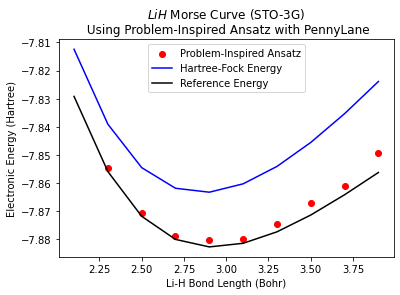

In [35]:
fig, ax = plt.subplots()
ax.scatter(bond_length_arr[1:],vqe_uccsd_energy[1:], label='Problem-Inspired Ansatz', color='r')
ax.plot(bond_length_arr,hf_reference_lih, label='Hartree-Fock Energy',color='b')
ax.plot(bond_length_arr,fci_reference_lih,label='Reference Energy', color='k')
ax.set_xlabel('Li-H Bond Length (Bohr)')
ax.set_ylabel('Electronic Energy (Hartree)')
ax.set_title(r'$LiH$ Morse Curve (STO-3G)'+f'\n Using Problem-Inspired Ansatz with PennyLane')
ax.legend()

### Discussion

Using our problem-inspired ansatz with PennyLane, we obtained a good energy convergence with a clear minimum at 2.9 Bohr with an estimated energy of -7.8804134 Hartree which is close to corresponding reference energy of -7.8827338 Hartree.

In [23]:
# save_data = {}
# save_data['header_names'] = ['bond_length', 'fci_ref_energy', 'hf_ref_energy', 'vqe_uccsd_energy', 'vqe_params', 'vqe_energy_hist', 'vqe_params_hist', ]
# save_data['bond_length'] = bond_length_arr
# save_data['fci_ref_energy'] = fci_reference_lih
# save_data['hf_ref_energy'] = hf_reference_lih
# save_data['vqe_uccsd_energy'] = vqe_uccsd_energy
# save_data['vqe_params'] = vqe_params
# save_data['vqe_energy_hist'] = vqe_energy_hist
# save_data['vqe_params_hist'] = vqe_params_hist
# getjson.save_to_json('lih_morse_vqe.json',save_data)

Saving Data to: lih_morse_vqe.json


### Qamuy PES Implementation

In [24]:
import qamuy.chemistry as qy
from qamuy.client import Client

In [26]:
# Define the array of bond lenghts
step_size_ = 0.2
min_length_ = 2.1
max_length_ = 3.9
bond_length_arr_ = 0.529177249 * np.arange(min_length_,max_length_+step_size_, step_size_) # Convert to Angstroms

# Create Lithium Hydride
mol_name = 'lih'
mol_symbols, coords, charge, num_elec = getmol.get_molecule(mol_name, bond_length_arr_[0])
new_coords = coords.reshape((2,3)).tolist()
setting = qy.QamuyChemistryInput()
molecule = setting.target_molecule
molecule.geometry = qy.molecule_geometry(mol_symbols, new_coords)
molecule.basis = "sto-3g"
molecule.multiplicity = 1
molecule.num_excited_states = 0

# Set Fermion to Spin Mapping
setting.mapping.type = "JORDAN_WIGNER"

# Set Quantum Algorithm 
setting.solver.type = "VQE"

# Set cost function
setting.cost_function.type = "NONE"

# Set ansatz
setting.ansatz.type = "UCCSD"
setting.ansatz.trotter_steps = 1
setting.ansatz.reference_state = 'RHF'
setting.ansatz.initial_parameter = [0]
setting.ansatz.use_random_initial_guess = False

# My Optimiser
setting.optimizer.type = "BFGS"

# Quantum Device
setting.quantum_device.type = "EXACT_SIMULATOR"

# Ab Inito Calculation For Reference
setting.post_hf_methods.append(qy.PostHFMethod(type="FCI"))

In [27]:
# Prepare Inputs for Jobs Submission
jobs = []
for distance in bond_length_arr_:
    new_input = copy.deepcopy(setting)
    mol_symbols, coords, charge, num_elec = getmol.get_molecule(mol_name, distance)
    new_coords = coords.reshape((2,3)).tolist()
    new_input.target_molecule.geometry = qy.molecule_geometry(mol_symbols, new_coords)
    jobs.append(client.submit(new_input))

In [28]:
# Submit Jobs for computation
results = client.wait_and_get_job_results(jobs)
outputs = [res.output for res in results]

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed: 29.2min remaining: 68.2min
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed: 61.2min remaining: 61.2min
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed: 81.5min remaining: 34.9min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 122.7min finished


### Results

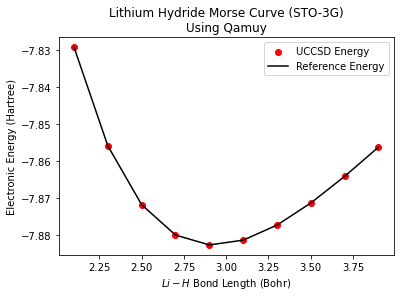

In [30]:
# Collate the Results
hf_energy_qamuy = np.zeros(len(bond_length_arr_))
ref_energy_qamuy = np.zeros(len(bond_length_arr_))
uccsd_energy_qamuy = np.zeros(len(bond_length_arr_))
for i in range(len(bond_length_arr_)):
    hf_energy = outputs[i].molecule_result.hf_result.evaluated_properties[0].energy.values[0].value
    ref_energy = outputs[i].molecule_result.post_hf_results[0].evaluated_properties[0].energy.values[0].value
    uccsd_energy = outputs[i].molecule_result.quantum_device_result.evaluated_properties[0].energy.values[0].value
    hf_energy_qamuy[i] = hf_energy
    ref_energy_qamuy[i] = ref_energy
    uccsd_energy_qamuy[i] = uccsd_energy

# Plot the Results
fig2, ax2 = plt.subplots()
ax2.scatter(bond_length_arr_/0.529177249,uccsd_energy_qamuy, label='UCCSD Energy', color='r')
# ax2.plot(bond_length_arr_/0.529177249,hf_energy_qamuy, label='Hartree-Fock Energy', color='b')
ax2.plot(bond_length_arr_/0.529177249,ref_energy_qamuy, label='Reference Energy', color='k')
ax2.set_xlabel(r"$Li-H$ Bond Length (Bohr)")
ax2.set_ylabel("Electronic Energy (Hartree)")
ax2.set_title("Lithium Hydride Morse Curve (STO-3G)\nUsing Qamuy")
ax2.legend()

### Discussion

Using Qamuy, its UCCSD ansatz have remarkable argreement with the reference energy. The Lithium Hydride Morse Curve shows a clear minimum around 2.9 Bohr at -7.8827240 Hartree which is extremely close to the reference energy of -7.8827338 Hartree up to the $4^{th}$ decimal place. This shows that both its UCCSD ansatz and VQE optimiser works extremely well in this example. 